
LOADING DATA FROM EXCEL FOR EVALUATION
✓ File loaded: Book1.xlsx
✓ Total rows to process: 11

BATCH PROCESSING & EVALUATION
Inisialisasi Slang Normalizer
Loading IndoBERT model...
Model loaded on: cpu
Slang dictionary: 250 entries
Formal words: 109 entries


Processing 1/11: Kadang nafsu untuk smash menggebu gebu.. tp begitu...
  >> Mencari padanan untuk 'nafsu' menggunakan BERT...
  >> Mencari padanan untuk 'smash' menggunakan BERT...
  >> Mencari padanan untuk 'menggebu' menggunakan BERT...
  >> Mencari padanan untuk 'gebu' menggunakan BERT...
     Tidak ada kandidat yang cocok, kata dipertahankan
  >> Mencari padanan untuk 'begitu' menggunakan BERT...
     Dipilih: 'malam' (similarity: 0.7897)
  >> Mencari padanan untuk 'dibalikin' menggunakan BERT...
  >> Mencari padanan untuk 'kesel' menggunakan BERT...
  >> Mencari padanan untuk 'sendiri' menggunakan BERT...
     Dipilih: 'yang' (similarity: 0.8124)
  >> Mencari padanan untuk 'paling' menggunakan BERT...
  >> Mencari padanan unt

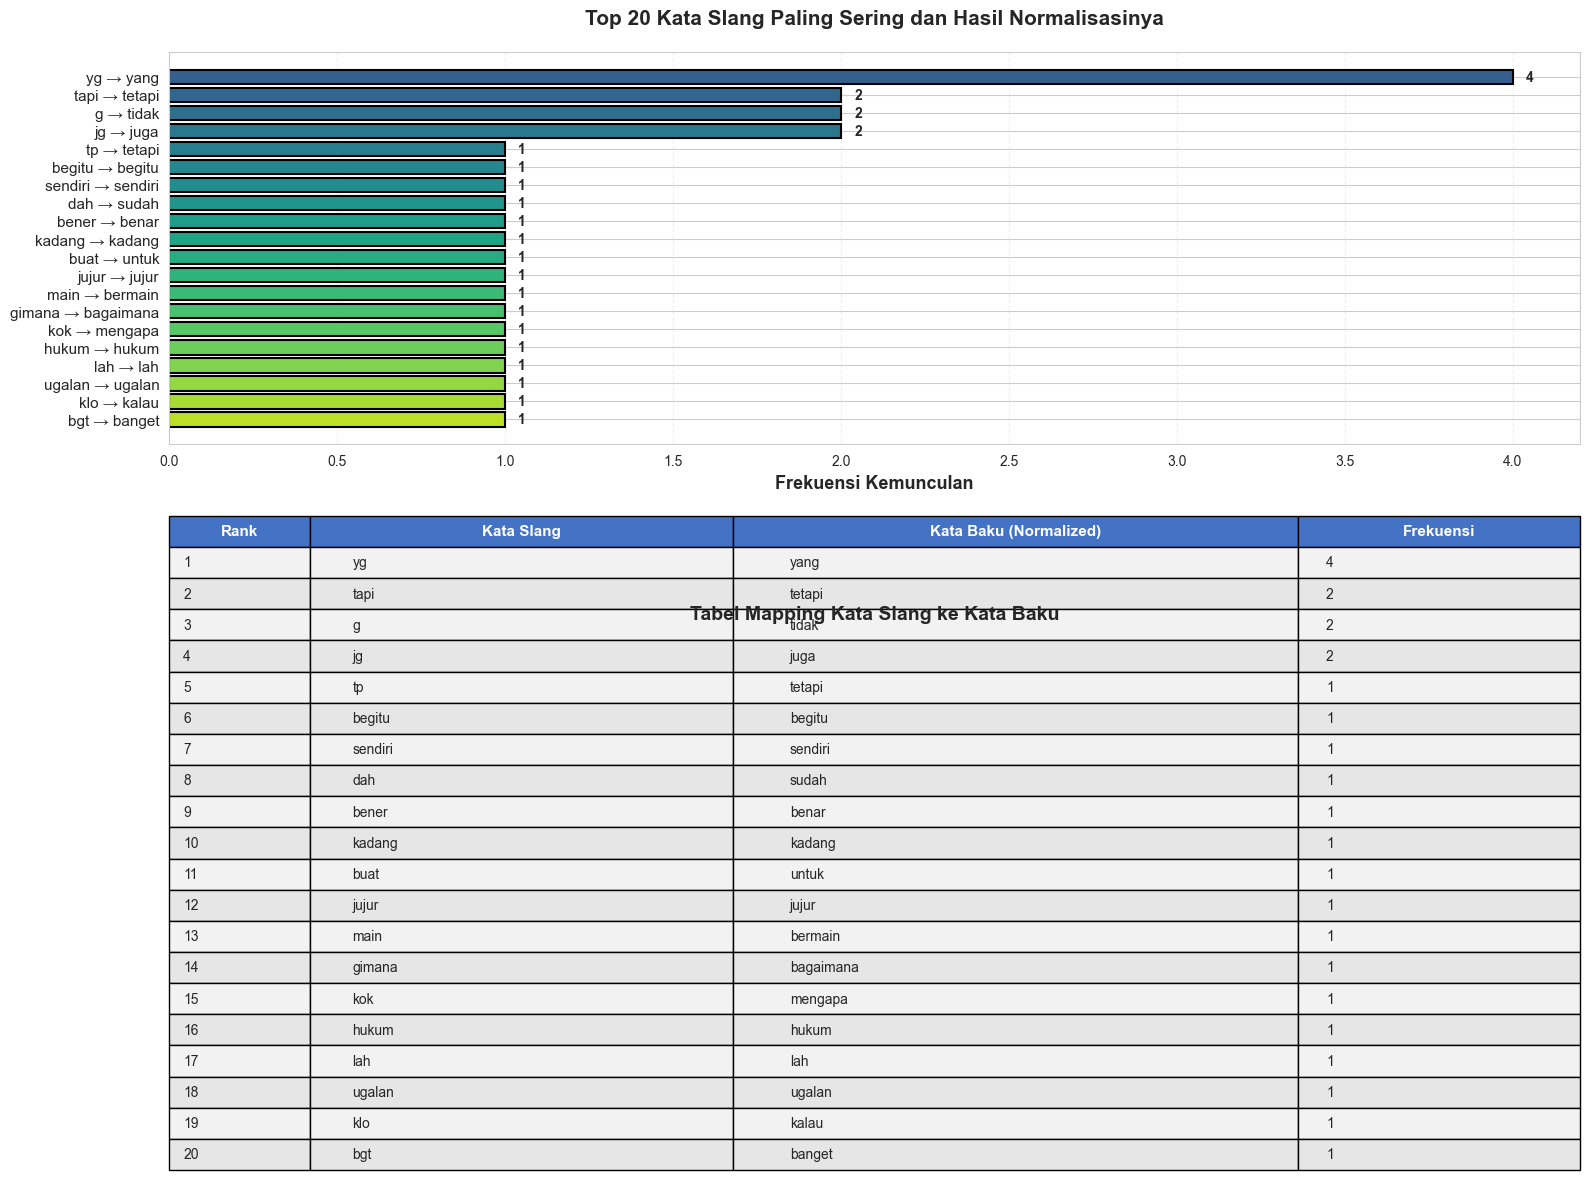

✓ Pie chart saved: output\slang_pie_chart.png


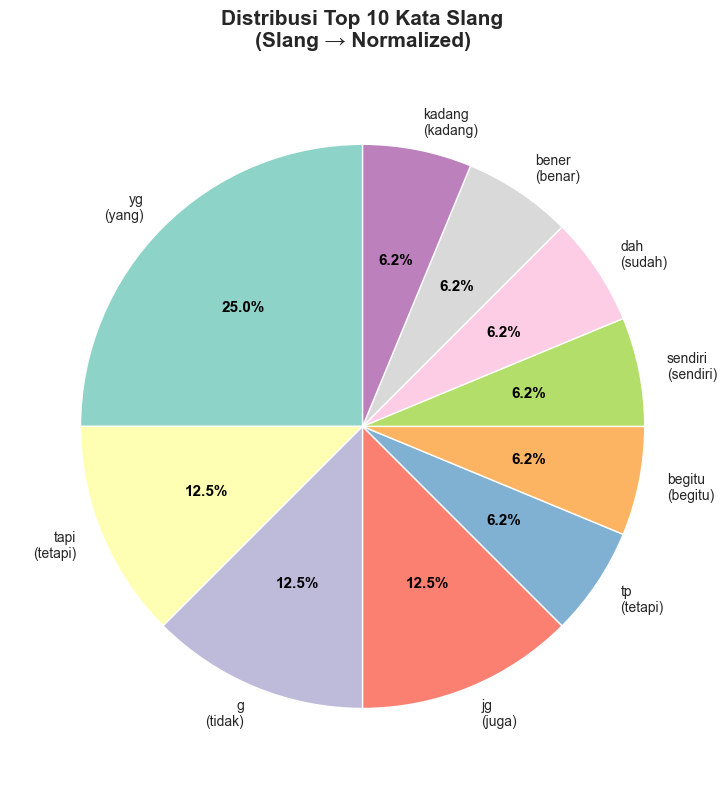


SUMMARY FREKUENSI KATA SLANG

Total unique slang words: 36
Total occurrences: 42

Top 10 Kata Slang:
   1. 'yg' → 'yang' : 4x (9.5%)
   2. 'tapi' → 'tetapi' : 2x (4.8%)
   3. 'g' → 'tidak' : 2x (4.8%)
   4. 'jg' → 'juga' : 2x (4.8%)
   5. 'tp' → 'tetapi' : 1x (2.4%)
   6. 'begitu' → 'begitu' : 1x (2.4%)
   7. 'sendiri' → 'sendiri' : 1x (2.4%)
   8. 'dah' → 'sudah' : 1x (2.4%)
   9. 'bener' → 'benar' : 1x (2.4%)
  10. 'kadang' → 'kadang' : 1x (2.4%)

✓ Hasil disimpan ke: output\hasil_normalisasi_dan_evaluasi1.csv


[1] Original          : Kadang nafsu untuk smash menggebu gebu.. tp begitu dibalikin kesel sendiri.. dah paling bener slice ...
    Normalized (Model): kadang nafsu untuk smash menggebu gebu tetapi malam dibalikin kesel yang sudah paling benar slice dr...
    Normalized (True) : kadang nafsu untuk smash menggebu-gebu tetapi begitu dibalikan kesal sendiri sudah paling benar slic...
    Detected Slang    : tp, begitu, sendiri, dah, bener, kadang
    True Slang        : tp, dah

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from pathlib import Path
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

warnings.filterwarnings('ignore')


class HybridSlangNormalizer:
   
    
    def __init__(self, model_name='indolem/indobert-base-uncased'):

        print("="*80)
        print("Inisialisasi Slang Normalizer")
        print("="*80)
        print("Loading IndoBERT model...")
        
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        print(f"Model loaded on: {self.device}")
        
        # Load dictionaries
        self.slang_dict = self.build_slang_dictionary()
        self.formal_words = self.build_formal_dictionary()
        self.stopwords = self.build_stopwords()
        
        print(f"Slang dictionary: {len(self.slang_dict)} entries")
        print(f"Formal words: {len(self.formal_words)} entries")
        print("="*80 + "\n")
    
    def build_slang_dictionary(self):

        d = {
            # Pronouns & Personal
            'gw': 'saya', 'gue': 'saya', 'ane': 'saya', 'ak': 'aku', 'w': 'saya',
            'lo': 'kamu', 'lu': 'kamu', 'elu': 'kamu', 'loe': 'kamu',
            
            # Common abbreviations
            'jg': 'juga', 'yg': 'yang', 'bgt': 'banget', 'bngt': 'banget', 'bgd': 'banget',
            'udh': 'sudah', 'udah': 'sudah', 'dah': 'sudah', 
            'blm': 'belum', 'blom': 'belum',
            'gmn': 'bagaimana', 'gimana': 'bagaimana',
            'knp': 'kenapa', 'napa': 'kenapa',
            'emg': 'memang', 'emang': 'memang',
            'skrg': 'sekarang', 'skg': 'sekarang',
            'gak': 'tidak', 'ga': 'tidak', 'g': 'tidak', 'nggak': 'tidak',
            'tp': 'tetapi', 'tapi': 'tetapi',
            'klo': 'kalau', 'kalo': 'kalau',
            'krn': 'karena', 'karna': 'karena',
            'dgn': 'dengan', 'ama': 'dengan',
            'utk': 'untuk', 'buat': 'untuk',
            'dr': 'dari', 'drpd': 'daripada',
            'aja': 'saja', 'aj': 'saja',
            'org': 'orang', 'orng': 'orang',
            'hrs': 'harus', 'mesti': 'harus', 'kudu': 'harus',
            'lgi': 'lagi', 'lg': 'lagi',
            'nih': 'ini', 'ni': 'ini',
            'tuh': 'itu', 'tu': 'itu',
            'bs': 'bisa', 'bsa': 'bisa',
            'brp': 'berapa', 'brapa': 'berapa',
            
            # Verbs
            'kerjain': 'mengerjakan', 'ngerjain': 'mengerjakan',
            'nulis': 'menulis', 'tulis': 'menulis',
            'baca': 'membaca', 'bc': 'membaca',
            'nonton': 'menonton', 'nntn': 'menonton',
            'denger': 'mendengar', 'liat': 'melihat',
            'ngomong': 'berbicara', 'omong': 'berbicara', 'blg': 'bilang',
            'makan': 'makan', 'mkn': 'makan',
            'minum': 'minum', 'tidur': 'tidur', 'tdr': 'tidur', 'bobo': 'tidur',
            'bangun': 'bangun', 'bgn': 'bangun',
            'pergi': 'pergi', 'pulang': 'pulang', 'plg': 'pulang',
            'datang': 'datang', 'dtg': 'datang',
            'main': 'bermain', 'maen': 'bermain',
            'tau': 'tahu', 'tw': 'tahu',
            'nanya': 'bertanya', 'tanya': 'bertanya',
            'jawab': 'menjawab', 'jwb': 'menjawab',
            'cari': 'mencari', 'nyari': 'mencari',
            'dapet': 'mendapat', 'dpet': 'dapat', 'dpt': 'dapat',
            'kasih': 'memberi', 'ksh': 'kasih',
            'ambil': 'mengambil', 'pikir': 'berpikir',
            'cb': 'coba', 'join': 'bergabung', 'ikut': 'ikut',
            
            # Adjectives
            'keren': 'keren', 'cool': 'keren', 'mantap': 'mantap', 'mantul': 'mantap',
            'bagus': 'bagus', 'bgs': 'bagus',
            'jelek': 'jelek', 'jlk': 'jelek',
            'gede': 'besar', 'gedhe': 'besar', 'bsr': 'besar',
            'kecil': 'kecil', 'kcl': 'kecil',
            'cepat': 'cepat', 'cpet': 'cepat', 'cpt': 'cepat',
            'lambat': 'lambat', 'lemot': 'lambat',
            'susah': 'sulit', 'gampang': 'mudah',
            'berat': 'berat', 'brt': 'berat',
            'ringan': 'ringan',
            
            # Time
            'mlm': 'malam', 'malem': 'malam',
            'pgi': 'pagi', 'pagi': 'pagi',
            'nanti': 'nanti', 'ntar': 'nanti',
            'kemarin': 'kemarin', 'kmrn': 'kemarin',
            'besok': 'besok', 'bsk': 'besok',
            'kadang': 'kadang', 'selalu': 'selalu',
            'sering': 'sering', 'srg': 'sering',
            'jarang': 'jarang',
            
            # Expressions
            'haha': 'tertawa', 'wkwk': 'tertawa', 'xixi': 'tertawa', 'hehe': 'tertawa',
            'wkwkwk': 'tertawa', 'hahaha': 'tertawa',
            'dong': 'dong', 'deh': 'deh', 'sih': 'sih', 'kok': 'mengapa',
            'lah': 'lah', 'loh': 'loh',
            'wow': 'wah', 'wah': 'wah', 'waduh': 'waduh', 'aduh': 'aduh',
            'asli': 'sungguh', 'bener': 'benar', 'bnr': 'benar',
            'pasti': 'pasti',
            
            # Courtesy
            'bro': 'saudara', 'sis': 'saudari', 'gan': 'juragan',
            'pls': 'tolong', 'plz': 'tolong', 'tlg': 'tolong',
            'thx': 'terima kasih', 'thanks': 'terima kasih', 'tq': 'terima kasih',
            'maap': 'maaf', 'sori': 'maaf', 'sorry': 'maaf',
            'hai': 'halo', 'hi': 'halo',
            'bye': 'selamat tinggal',
            
            # Internet slang
            'btw': 'ngomong ngomong', 'fyi': 'untuk informasi',
            'asap': 'segera', 'otw': 'sedang dalam perjalanan',
            'idk': 'tidak tahu', 'idc': 'tidak peduli',
            'lol': 'tertawa', 'omg': 'ya ampun',
            
            # Others
            'pengen': 'ingin', 'pgn': 'ingin', 'mau': 'mau', 'mo': 'mau',
            'butuh': 'butuh', 'perlu': 'perlu',
            'gmw': 'tidak mau',
            'kyk': 'seperti', 'kayak': 'seperti', 'kaya': 'seperti', 'kek': 'seperti',
            'beda': 'berbeda', 'sama': 'sama', 'sm': 'sama',
            'ybs': 'yang bersangkutan',
            'dospem': 'dosen pembimbing',
            'dosen': 'dosen', 'dsn': 'dosen',
            'mahasiswa': 'mahasiswa', 'mhs': 'mahasiswa',
            'kuliah': 'kuliah', 'tugas': 'tugas', 'tgs': 'tugas',
            'ujian': 'ujian', 'nilai': 'nilai',
            'skripsi': 'skripsi', 'semester': 'semester', 'smt': 'semester',
            'dimana': 'dimana', 'dmn': 'dimana', 'mana': 'mana',
            'kemana': 'kemana', 'rumah': 'rumah', 'rmh': 'rumah',
            'kampus': 'kampus', 'tempat': 'tempat',
            'banyak': 'banyak', 'byk': 'banyak', 'bnyk': 'banyak',
            'sedikit': 'sedikit', 'dikit': 'sedikit',
            'semua': 'semua', 'smua': 'semua',
            'berngkt': 'berangkat', 'dipake': 'dipakai',
            'kadangkadang': 'kadang kadang', 'ninggalin': 'meninggalkan',
            'to': 'untuk', 'kepo': 'ingin tahu', 'baper': 'terbawa perasaan',
            'santuy': 'santai', 'gabut': 'tidak ada kegiatan',
            'bucin': 'budak cinta', 'php': 'pemberi harapan palsu',
            'gmnsi': 'bagaimana sih', 'dlm': 'dalam', 'mslh': 'masalah',
            'pmakaian': 'pemakaian', 'gda': 'tidak ada', 'mandang': 'memandang',
            'mending': 'lebih baik', 'ny': 'nya', 'nyampur': 'bercampur'
        }
        return d
    
    def build_formal_dictionary(self):

        words = {
            'saya', 'aku', 'kamu', 'dia', 'kami', 'kita', 'mereka', 
            'ini', 'itu', 'ada', 'adalah', 'akan', 'sudah', 'belum', 'sedang',
            'yang', 'dengan', 'untuk', 'dari', 'ke', 'di', 'pada',
            'dalam', 'luar', 'atas', 'bawah', 'depan', 'belakang',
            'baik', 'buruk', 'besar', 'kecil', 'tinggi', 'rendah',
            'banyak', 'sedikit', 'semua', 'tidak', 'bukan', 'jangan',
            'dapat', 'bisa', 'harus', 'boleh', 'mau', 'ingin',
            'pergi', 'datang', 'pulang', 'masuk', 'keluar',
            'makan', 'minum', 'tidur', 'bangun', 'kerja', 'main',
            'lihat', 'dengar', 'baca', 'tulis', 'bicara', 'kata',
            'dan', 'atau', 'tetapi', 'namun', 'karena', 'jika',
            'apa', 'siapa', 'mana', 'kapan', 'mengapa', 'bagaimana',
            'orang', 'anak', 'rumah', 'sekolah', 'kampus', 'kantor',
            'hari', 'waktu', 'pagi', 'siang', 'sore', 'malam',
            'mahasiswa', 'dosen', 'guru', 'murid', 'kuliah', 'belajar',
            'tugas', 'ujian', 'nilai', 'skripsi', 'penelitian',
            'benar', 'salah', 'mudah', 'sulit', 'cepat', 'lambat',
            'senang', 'sedih', 'marah', 'takut', 'berani'
        }
        return words
    
    def build_stopwords(self):

        return {
            'yang', 'untuk', 'pada', 'ke', 'di', 'dari', 'dan', 'atau',
            'adalah', 'ini', 'itu', 'dalam', 'dengan', 'oleh', 'sebagai',
            'akan', 'sudah', 'telah', 'saya', 'dia', 'mereka'
        }
    
    def clean_text(self, text):

        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def remove_stopwords(self, text):
        words = text.split()
        return ' '.join([w for w in words if w not in self.stopwords])
    
    def find_slang_words(self, text):
        words = text.split()
        found_slang = []
        unknown_words = []
        
        for word in words:
            if word in self.slang_dict:
                found_slang.append(word)
            elif len(word) > 2 and word not in self.formal_words:
                unknown_words.append(word)
        
        return found_slang, unknown_words
    
    def get_embedding(self, word):
        inputs = self.tokenizer(word, return_tensors='pt', 
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.cpu().numpy()
    
    def get_batch_embeddings(self, words):
        inputs = self.tokenizer(words, return_tensors='pt', 
                                padding=True, truncation=True, max_length=128)
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = self.model(**inputs)
        
        embeddings = outputs.last_hidden_state.mean(dim=1)
        return embeddings.cpu().numpy()
    
    def find_similar_words(self, word, candidates=None, top_k=5, min_similarity=0.70):
        if candidates is None:
            candidates = list(self.formal_words)
        
        word_emb = self.get_embedding(word)
        
        # Proses dalam batch untuk efisiensi
        batch_size = 100
        all_similarities = []
        
        for i in range(0, len(candidates), batch_size):
            batch = candidates[i:i+batch_size]
            batch_embs = self.get_batch_embeddings(batch)
            
            sims = cosine_similarity(word_emb, batch_embs)[0]
            
            for j, candidate in enumerate(batch):
                if sims[j] >= min_similarity:
                    all_similarities.append((candidate, float(sims[j])))
        
        all_similarities.sort(key=lambda x: x[1], reverse=True)
        return all_similarities[:top_k]
    
    def normalize_text(self, text, use_stopword_removal=False):
        # Step 1: Cleaning
        cleaned = self.clean_text(text)
        
        # Step 2: Stopword removal (optional)
        if use_stopword_removal:
            processed = self.remove_stopwords(cleaned)
        else:
            processed = cleaned
        
        # Step 3: Identifikasi kata slang
        known_slang, unknown_words = self.find_slang_words(processed)
        
        # Step 4: Normalisasi hybrid
        words = processed.split()
        normalized_words = []
        bert_results = {}
        
        # Combine known slang and unknown words to get all detected slang
        detected_slang = set(known_slang)
        
        for word in words:
            if word in self.slang_dict:
                # Metode 1: Gunakan dictionary
                normalized_words.append(self.slang_dict[word])
            elif word in unknown_words:
                # Metode 2: Gunakan BERT untuk kata yang tidak dikenal
                print(f"  >> Mencari padanan untuk '{word}' menggunakan BERT...")
                similar = self.find_similar_words(word, top_k=5, min_similarity=0.70)
                
                if similar and similar[0][1] > 0.75:
                    # Gunakan kandidat terbaik jika similarity tinggi
                    best_match = similar[0][0]
                    normalized_words.append(best_match)
                    bert_results[word] = similar
                    detected_slang.add(word) # Consider this a detected slang
                    print(f"     Dipilih: '{best_match}' (similarity: {similar[0][1]:.4f})")
                else:
                    # Pertahankan kata asli jika tidak ada kandidat yang cocok
                    normalized_words.append(word)
                    if similar:
                        bert_results[word] = similar
                        print(f"     Tidak ada kandidat yang cocok, kata dipertahankan")
            else:
                # Kata formal, pertahankan
                normalized_words.append(word)
        
        return {
            'original': text,
            'cleaned': cleaned,
            'processed': processed,
            'detected_slang': list(detected_slang),
            'hybrid_normalized': ' '.join(normalized_words),
            'bert_mappings': bert_results
        }
    
    def add_custom_slang(self, slang_dict):

        self.slang_dict.update(slang_dict)
        print(f"✓ Added {len(slang_dict)} new slang entries")
        print(f"✓ Total slang dictionary: {len(self.slang_dict)} entries")



def evaluate_detection(predicted_slang, true_slang):

    predicted_set = set(predicted_slang)
    true_set = set(true_slang)
    
    tp = len(predicted_set.intersection(true_set))
    fp = len(predicted_set.difference(true_set))
    fn = len(true_set.difference(predicted_set))
    
    # Hitung metrik, hindari pembagian dengan nol
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    }

def evaluate_normalization(normalized_text, reference_text):

    # SmoothingFunction membantu jika tidak ada overlap n-gram
    chencherry = SmoothingFunction().method1
    
    # BLEU score dihitung pada token, jadi split kalimat menjadi kata
    reference = [reference_text.split()]
    candidate = normalized_text.split()
    
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=chencherry)
    return bleu_score

def display_evaluation_report(df_results):

    print("\n" + "="*80)
    print("EVALUATION REPORT")
    print("="*80)
    
    # Rata-rata metrik evaluasi
    avg_precision = df_results['precision'].mean()
    avg_recall = df_results['recall'].mean()
    avg_f1 = df_results['f1_score'].mean()
    avg_bleu = df_results['bleu_score'].mean()
    
    print("\n--- Slang Detection Performance ---")
    print(f"  - Average Precision : {avg_precision:.4f}")
    print(f"  - Average Recall    : {avg_recall:.4f}")
    print(f"  - Average F1-Score  : {avg_f1:.4f}")
    
    print("\n--- Normalization Quality ---")
    print(f"  - Average BLEU Score: {avg_bleu:.4f}")
    print("\n" + "="*80)

    # def display_descriptive_analysis(df_result):
    # """
    # Menampilkan ringkasan analisis deskriptif dari hasil normalisasi.
    # """
    # print("\n" + "="*80)
    # print("EVALUASI: ANALISIS DESKRIPTIF HASIL")
    # print("="*80)
    
    # total_rows = len(df_result)
    # # Pastikan 'detected_slang' adalah list/set sebelum pengecekan
    # rows_with_slang = sum(1 for slangs in df_result['detected_slang'] if slangs)
    
    # all_slang_words = []
    # for slang_list in df_result['detected_slang']:
    #     if slang_list: # Pastikan tidak kosong
    #         all_slang_words.extend(slang_list)
            
    # total_slang_detected = len(all_slang_words)
    # unique_slang_detected = len(set(all_slang_words))
    
    # print(f"Total Teks Diproses        : {total_rows}")
    # print(f"Teks Mengandung Slang      : {rows_with_slang} ({rows_with_slang/total_rows:.1%})")
    # print("-" * 40)
    # print(f"Total Kata Slang Ditemukan   : {total_slang_detected} (dari {unique_slang_detected} kata unik)")
    
    # if all_slang_words:
    #     slang_counter = Counter(all_slang_words)
    #     print("\n--- Top 10 Kata Slang Paling Sering Ditemukan ---")
    #     for word, count in slang_counter.most_common(10):
    #         print(f"  - {word:<15} : {count} kali")
            
    # print("="*80)

def process_batch_from_excel(filepath, text_col='instagram', true_slang_col='true_slang', true_norm_col='true_normalized', batch_size=10):

    print("\n" + "="*80)
    print("LOADING DATA FROM EXCEL FOR EVALUATION")
    print("="*80)
    
    try:
        df = pd.read_excel(filepath)
        print(f"✓ File loaded: {filepath}")
        
        required_cols = [text_col, true_slang_col, true_norm_col]
        # Validasi kolom
        if not all(col in df.columns for col in required_cols):
            print(f"❌ Error: Missing one or more required columns!")
            print(f"Required columns: {', '.join(required_cols)}")
            print(f"Available columns: {', '.join(df.columns)}")
            return None, None
            
        df = df.dropna(subset=[text_col])
        print(f"✓ Total rows to process: {len(df)}")
        
    except FileNotFoundError:
        print(f"❌ Error: File not found: {filepath}")
        return None, None
    except Exception as e:
        print(f"❌ Error loading file: {str(e)}")
        return None, None
    
    print("\n" + "="*80)
    print("BATCH PROCESSING & EVALUATION")
    print("="*80)
    
    normalizer = HybridSlangNormalizer()
    results = []
    total = len(df)
    
    for idx, row in df.iterrows():
        text = str(row[text_col])
        # Ambil data ground truth
        true_slang_str = str(row[true_slang_col])
        true_normalized = str(row[true_norm_col])
        
        # Split string slang menjadi list
        true_slang_list = [s.strip() for s in true_slang_str.split(',') if s.strip()]
        
        print(f"\nProcessing {idx + 1}/{total}: {text[:50]}...")
        
        # Normalisasi
        result = normalizer.normalize_text(text, use_stopword_removal=False)
        
        # Evaluasi
        detection_metrics = evaluate_detection(result['detected_slang'], true_slang_list)
        bleu_score = evaluate_normalization(result['hybrid_normalized'], true_normalized)
        
        results.append({
            'original': result['original'],
            'hybrid_normalized': result['hybrid_normalized'],
            'true_normalized': true_normalized, # Simpan referensi untuk perbandingan
            'detected_slang': ', '.join(result['detected_slang']),
            'true_slang': ', '.join(true_slang_list), # Simpan referensi
            'bert_used_count': len(result['bert_mappings']),
            'precision': detection_metrics['precision'],
            'recall': detection_metrics['recall'],
            'f1_score': detection_metrics['f1_score'],
            'bleu_score': bleu_score
        })
        
        if (idx + 1) % batch_size == 0:
            print(f"Progress: {idx + 1}/{total} ({(idx+1)/total*100:.1f}%)")
    
    print(f"\n✓ Selesai: {total}/{total} (100.0%)")
    return pd.DataFrame(results), normalizer

def analyze_results(df_result):

    print("\n" + "="*80)
    print("ANALISIS HASIL")
    print("="*80)
    
    total = len(df_result)
    bert_used = len(df_result[df_result['bert_used_count'] > 0])
    
    print(f"\nTotal teks: {total}")
    print(f"Teks yang menggunakan BERT: {bert_used} ({bert_used/total*100:.1f}%)")
    print(f"Total normalisasi BERT: {df_result['bert_used_count'].sum()}")
    print(f"Rata-rata normalisasi BERT per teks: {df_result['bert_used_count'].mean():.2f}")
    
    # Top slang
    all_slang = []
    for slang in df_result['detected_slang']:
        if slang:
            all_slang.extend([s.strip() for s in slang.split(',')])
    
    slang_counter = None
    if all_slang:
        slang_counter = Counter(all_slang)
        print(f"\nTop 10 kata slang terdeteksi:")
        for word, count in slang_counter.most_common(10):
            print(f"  {word}: {count}x")
    
    print("="*80)
    return slang_counter

# Functions visualize_slang_frequency, save_to_csv remain the same
def visualize_slang_frequency(df_result, normalizer, top_n=20, save_dir='output'):

    # Buat directory output jika belum ada
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.figsize'] = (16, 10)
    
    # Kumpulkan semua kata slang
    all_slang = []
    # MODIFIED: use 'detected_slang' column
    for slang_words in df_result['detected_slang']:
        if slang_words:
            all_slang.extend([s.strip() for s in slang_words.split(',')])
    
    if not all_slang:
        print("Tidak ada kata slang yang ditemukan untuk divisualisasikan")
        return
    
    # Hitung frekuensi
    slang_counter = Counter(all_slang)
    top_slang = slang_counter.most_common(top_n)
    
    # Siapkan data untuk visualisasi
    slang_words = [item[0] for item in top_slang]
    frequencies = [item[1] for item in top_slang]
    normalized_words = [normalizer.slang_dict.get(word, word) for word in slang_words]
    
    # Buat labels dengan format "slang → normalized (count)"
    labels = [f"{slang} → {norm}" for slang, norm in zip(slang_words, normalized_words)]
    
    # ============ SUBPLOT 1 & 2: Bar Chart dan Tabel ============
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))
    
    # Bar Chart
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(slang_words)))
    bars = ax1.barh(range(len(slang_words)), frequencies, color=colors, edgecolor='black', linewidth=1.5)
    
    ax1.set_yticks(range(len(slang_words)))
    ax1.set_yticklabels(labels, fontsize=11)
    ax1.set_xlabel('Frekuensi Kemunculan', fontsize=13, fontweight='bold')
    ax1.set_title(f'Top {top_n} Kata Slang Paling Sering dan Hasil Normalisasinya', 
                  fontsize=15, fontweight='bold', pad=20)
    ax1.invert_yaxis()
    
    # Tambahkan nilai di ujung bar
    for i, (bar, freq) in enumerate(zip(bars, frequencies)):
        width = bar.get_width()
        ax1.text(width + max(frequencies)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{freq}',
                 ha='left', va='center', fontsize=10, fontweight='bold')
    
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Tabel
    ax2.axis('tight')
    ax2.axis('off')
    
    table_data = []
    for i, (slang, norm, freq) in enumerate(zip(slang_words, normalized_words, frequencies), 1):
        table_data.append([i, slang, norm, freq])
    
    table = ax2.table(cellText=table_data,
                      colLabels=['Rank', 'Kata Slang', 'Kata Baku (Normalized)', 'Frekuensi'],
                      cellLoc='left',
                      loc='center',
                      colWidths=[0.1, 0.3, 0.4, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Warna header
    for i in range(4):
        cell = table[(0, i)]
        cell.set_facecolor('#4472C4')
        cell.set_text_props(weight='bold', color='white', fontsize=11)
    
    # Warna baris bergantian
    for i in range(1, len(table_data) + 1):
        for j in range(4):
            cell = table[(i, j)]
            if i % 2 == 0:
                cell.set_facecolor('#E7E6E6')
            else:
                cell.set_facecolor('#F2F2F2')
    
    ax2.set_title('Tabel Mapping Kata Slang ke Kata Baku', 
                  fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'slang_frequency_chart.png'), dpi=300, bbox_inches='tight')
    print(f"✓ Chart saved: {os.path.join(save_dir, 'slang_frequency_chart.png')}")
    plt.show()
    
    # ============ Pie Chart untuk Top 10 ============
    if len(slang_words) >= 10:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        top_10_words = slang_words[:10]
        top_10_freqs = frequencies[:10]
        top_10_normalized = normalized_words[:10]
        
        pie_labels = [f"{slang}\n({norm})" for slang, norm in zip(top_10_words, top_10_normalized)]
        
        colors_pie = plt.cm.Set3(range(10))
        wedges, texts, autotexts = ax.pie(top_10_freqs, 
                                          labels=pie_labels,
                                          autopct='%1.1f%%',
                                          colors=colors_pie,
                                          startangle=90,
                                          textprops={'fontsize': 10})
        
        for autotext in autotexts:
            autotext.set_color('black')
            autotext.set_fontweight('bold')
            autotext.set_fontsize(11)
        
        ax.set_title('Distribusi Top 10 Kata Slang\n(Slang → Normalized)', 
                     fontsize=15, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, 'slang_pie_chart.png'), dpi=300, bbox_inches='tight')
        print(f"✓ Pie chart saved: {os.path.join(save_dir, 'slang_pie_chart.png')}")
        plt.show()
    
    # Print Summary
    print("\n" + "="*80)
    print("SUMMARY FREKUENSI KATA SLANG")
    print("="*80)
    print(f"\nTotal unique slang words: {len(slang_counter)}")
    print(f"Total occurrences: {sum(slang_counter.values())}")
    print(f"\nTop {min(10, len(top_slang))} Kata Slang:")
    for i, (word, count) in enumerate(top_slang[:10], 1):
        normalized = normalizer.slang_dict.get(word, word)
        percentage = (count / sum(slang_counter.values())) * 100
        print(f"  {i:2d}. '{word}' → '{normalized}' : {count}x ({percentage:.1f}%)")
    print("="*80)
    
    return slang_counter


def save_to_csv(df_result, filename='hasil_normalization.csv', output_dir='output'):

    # Buat directory jika belum ada
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    filepath = os.path.join(output_dir, filename)
    df_result.to_csv(filepath, index=False, encoding='utf-8-sig')
    print(f"\n✓ Hasil disimpan ke: {filepath}")

def main():

    excel_file = 'Book1.xlsx'  
    text_column = 'instagram'
    true_slang_column = 'true_slang'       
    true_normalized_column = 'true_normalized' 
    
    # Proses data dari Excel
    df_result, normalizer = process_batch_from_excel(
        filepath=excel_file,
        text_col=text_column,
        true_slang_col=true_slang_column,
        true_norm_col=true_normalized_column,
        batch_size=11
    )
    
    if df_result is None or normalizer is None:
        print("❌ Gagal memproses data. Program dihentikan.")
        return
    
    # Tampilkan laporan evaluasi
    display_evaluation_report(df_result)
    
    # Analisis hasil (frekuensi slang, dll.)
    slang_counter = analyze_results(df_result)
    
    # Visualisasi
    print("\n" + "="*80)
    print("VISUALISASI FREKUENSI KATA SLANG")
    print("="*80)
    
    visualize_slang_frequency(df_result, normalizer, top_n=20, save_dir='output')
    
    # Save hasil ke CSV
    save_to_csv(df_result, 'hasil_normalisasi_dan_evaluasi1.csv', 'output')
    
    # Tampilkan beberapa contoh hasil untuk perbandingan
    print("\n" + "="*80)

    for idx, row in df_result.head(5).iterrows():
        print(f"\n[{idx+1}] Original          : {row['original'][:100]}...")
        print(f"    Normalized (Model): {row['normalized'][:100]}...")
        print(f"    Normalized (True) : {row['true_normalized'][:100]}...")
        print(f"    Detected Slang    : {row['detected_slang']}")
        print(f"    True Slang        : {row['true_slang']}")
        print(f"    Scores -> P: {row['precision']:.2f}, R: {row['recall']:.2f}, F1: {row['f1_score']:.2f}, BLEU: {row['bleu_score']:.2f}")
    
    print("\n" + "="*80)
    print("PROSES SELESAI!")
    print("="*80)
    print(f"✓ Total teks diproses dan dievaluasi: {len(df_result)}")
    print(f"✓ File hasil tersimpan di folder 'output'")
    print(f"✓ CSV: output/hasil_normalisasi_dan_evaluasi.csv")
    print("="*80)


if __name__ == "__main__":
    main()